# Core functionality tutorial
This notebook will go over each primitive in the package and show their intended use.

In [83]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qhierarchy,
    Qcycle,
    Qpermute,
    Qmask,
    Qunmask,
    Qinit,
    Qmotif,
    Qmotifs,
    plot_motif,
    Qunitary,
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [84]:
backend = "qiskit"

In [85]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer capturing some design motif (cycle, mask, etc) and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - architecture = (Cycle, Mask, Cycle, Mask, Cycle, Cycle, Cycle, Mask, Cycle, Mask)

**Hierarchical view**
 - m2_1 = (Cycle, Mask)
 - m2_2 = (Cycle, Cycle)
 - m3_1 = (m2_1, m2_1)
 - architecture = (m3_1, m2_2, m3_1)

 <img src="https://github.com/matt-lourens/hierarqcal/blob/master/img/hierarchical_motifs.drawio.png?raw=true" >
 Consider the figure above, to create the architecture on the right we want to **repeat the alternation between a cycle of stride 1 and masking from bottom to top three times**. The semantic description is simple and intuitive, the package is designed to allow building circuits this way. Notice a cycle of stride 1 and masking from bottom to top are both primitves. Alternating between them, is a level two motif (p1+p2), then repeating that 3 times is a level 3 motif. This gives a concise description of the circuit on the right. The circuit being a binary tree architecture (which is hierarchical).

There are two main classes to generate circuit architectures: `Qhierarchy` and `Qmotif`. We call our building blocks primitives, all are instances of `Qmotif`. A primitive is a directed graph with nodes representing qubits and edges unitaries applied between them. The edges are determined by its rules and the number of available qubits. Primitives are stacked with addition or mutliplication operations which act as append and extend, ex: `Qcycle()+Qpermute() = (Qcycle,Qpermute)` which is a `Qmotifs` object, a sequence of `Qmotif`. Simlarly `Qcycle()*3 = (Qcycle(), Qcycle(), Qcycle)` is again an instance of `Qmotifs`. Note it's possible to add motifs together without specifying qubits, when you have a motif ready, it's initialized with `Qinit` in the following way: `Qinit(8)+motif`. This creates a `Qhierarchy` object, which runs through all the motifs generates their edges.

 The types of primitves are:
 - `Qcycle`: Create a cycle of unitaries, sometimes called `ladders` or `convolutions`. It's hyperparamaters are used to generate cycles in directed graphs
 - `Qpermute`: unitaries permuted across qubits.
 - `Qmask`: Mask certain qubits based on a pattern, a mapping can be provided to *save* it's information. Also reffered to as `entanglers` or `pooling` layers.
 - `Qunmask`: Unmask previously masked unitaries
 - `Qinit`: specify the qubit names, order and amount.

### Qunitary
The edges of primitves encode the connectivity of the unitary, 1-qubit unitaries correspond to edges with arity 1 (1-ary tuples primitive.E=[(1,),(2),,...]). 2 qubit unitaries correspond to 2-ary tuples primitive.E=[(1,2),(3,4),...] and `N`-qubit unitaries to N-ary tuples ex: primitive.E=[(1,2,...,7),(3,4,...,8),...]. `Qunitary` tells a primitive the arity of it's operation, each primitive has a mapping hyperparamater that expects a `Qunitary` object. The arguments for `Qunitary` are:

 - function: the function that get's executed at every edge
 - n_symbols: the number of symbols the function expects
 - arity: the arity of the function (number of qubits it acts upon)

Notice that any function is permitted, there is no restriction to unitarity or even quantumness. In this sense the package is a dynamic datatrstructe to construct of hierarchichal compute graphs, but we work mainly in the context of quantum computing. This is also why the packages is framework agnostic, since no matter the framework, you will be able to create a function that does it's circuit execution. HierarQcal manages the order in which these circuits get executed (well it generates the order, and number of executions.). For creating architectures, we only need to know the arity and number of symbols our function expects. This way, you can generate a circuit architecture without specifying the specific function corresponding to a unitary and framework. Once the architecture is ready, you can specify the functions and execute it on a backend by calling `hierq(backend="qiskit")` where `hierq` is the `Qhierarchy` object containing the architecture (or more generally, the compute graph).

For the examples below, we specify an arbitrary `Qunitary` object with no specific function connected to it:

In [86]:
u0_1 = Qunitary(function=None, n_symbols=0, arity=1)
u0_2 = Qunitary(function=None, n_symbols=0, arity=2)
u1_2 = Qunitary(function=None, n_symbols=1, arity=2)
u2_3 = Qunitary(function=None, n_symbols=2, arity=3)
u2_4 = Qunitary(function=None, n_symbols=2, arity=4)

### Qinit primitive
`Qinit` is a special primitive with no operational effect. It initializes a set of qubit labels as reference for operations. `Qinit` is always provided at the start of a statement ex: `Qinit(3)+motifs` which causes a `Qhierarchy` object to be created. `Qhierarchy` manages the edge creation of motifs. Use `Qinit` is usually used in the final statement combining all motifs into an architecture or in statements that create sub hierarchies. Providing an integer $n$ labels the qubits $1, 2, \dots, n$, but providing a list with specific qubit order is also possible:

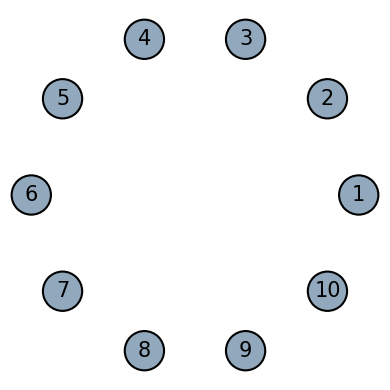

In [87]:
init_primitive = Qinit(10)
fig, ax = plot_motif(init_primitive)

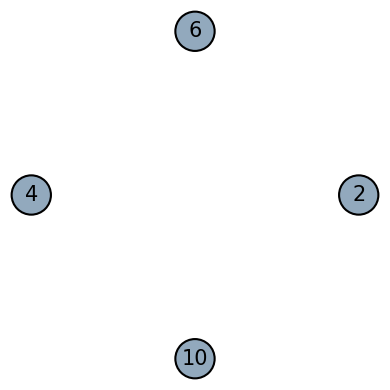

In [88]:
init_primitive = Qinit([2,6,4,10])
fig, ax = plot_motif(init_primitive)

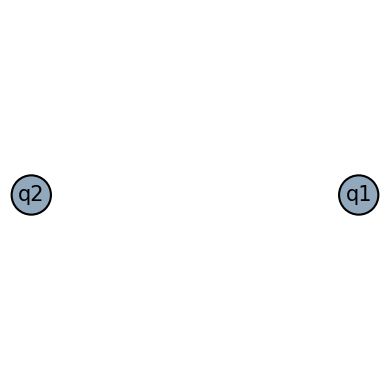

In [89]:
init_primitive = Qinit(["q1", "q2"])
fig, ax = plot_motif(init_primitive)

### Cycle primitive
`Qcycle` is a primitve that creates a cycle or ladder or convolution of unitaries. It has four main hyperparameters:
 - `stride`: The number of nodes to skip, before connecting the edge
 - `step`: The number of nodes to step over after the edge was connected
 - `offset`: The node to start the procedure with
 - `boundary`: The boundary condition of the cycle, can be `open` or `periodic`
The action is best seen through examples, but the general procedure for edge creation is staring at `offset` step in units of `step` at each `step` connect to `stride` units away.

In [90]:
# Convolution of stride 3, try out other stride values
cycle = Qcycle(stride=5, mapping=u1_2)
cycle_on_8_qubits = Qinit(8) + cycle

# Note the type of 'conv_on_8_qubits', it's a qcnn with two motifs: (Qfree, Qconv)
print(f"Type of object\t {type(cycle_on_8_qubits)}")
print(f"First motif\t {type(cycle_on_8_qubits.tail)}")
print(f"Second motif\t {type(cycle_on_8_qubits.tail.next)}")

Type of object	 <class 'hierarqcal.core.Qhierarchy'>
First motif	 <class 'hierarqcal.core.Qinit'>
Second motif	 <class 'hierarqcal.core.Qcycle'>


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

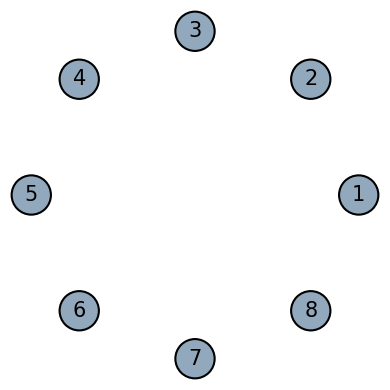

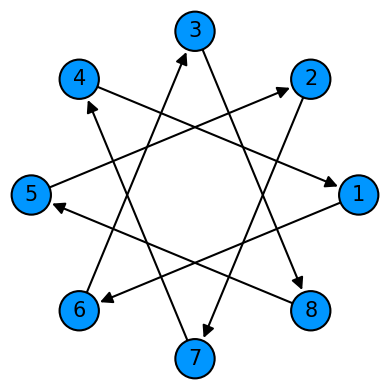

In [91]:
plot_motif(cycle_on_8_qubits[0])
plot_motif(cycle_on_8_qubits[1])

#### Stride examples

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

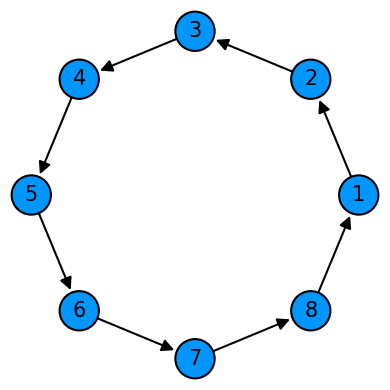

In [92]:

cycle = Qcycle(stride=1, step=1,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

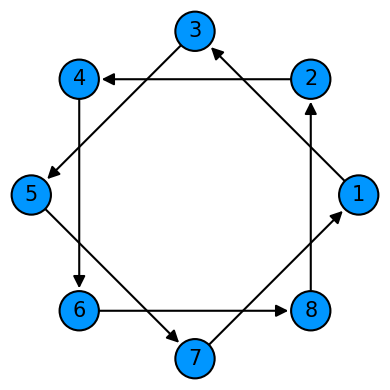

In [93]:
cycle = Qcycle(stride=2, step=1,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

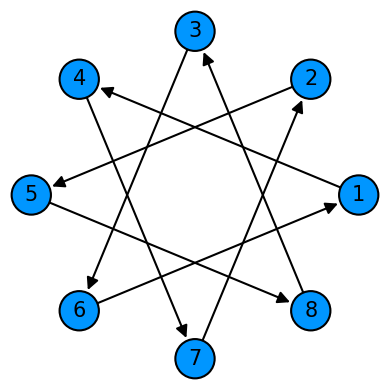

In [94]:
cycle = Qcycle(stride=3, step=1,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

#### Step examples

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

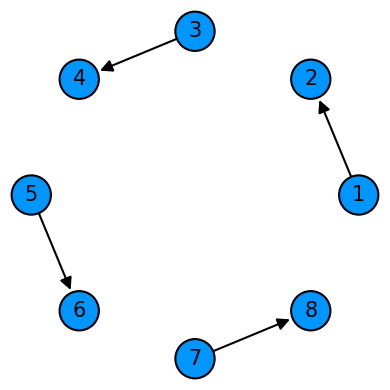

In [95]:
cycle = Qcycle(stride=1, step=2,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

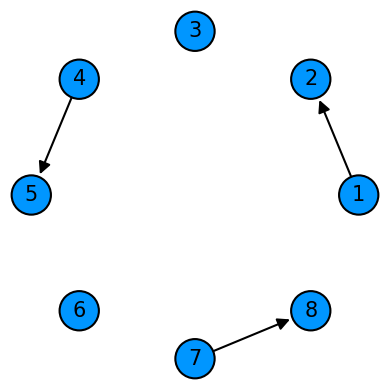

In [96]:
cycle = Qcycle(stride=1, step=3,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

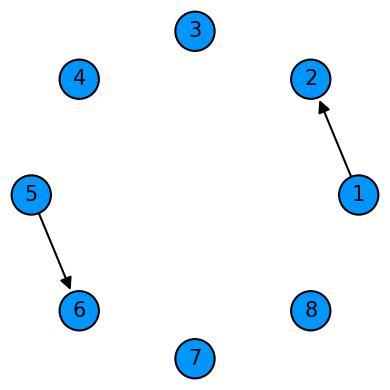

In [97]:
cycle = Qcycle(stride=1, step=4,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

#### Offset examples

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

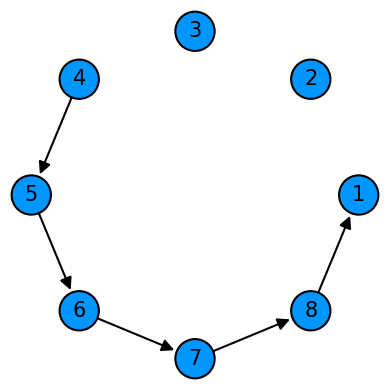

In [98]:
cycle = Qcycle(stride=1, step=1,offset=3, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

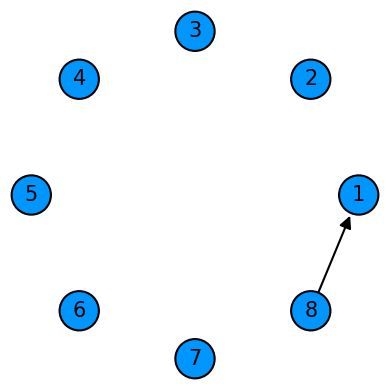

In [99]:
cycle = Qcycle(stride=1, step=1,offset=7, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

#### Boundary examples

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

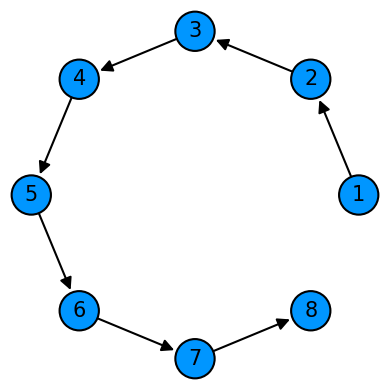

In [100]:
cycle = Qcycle(stride=1, step=1,offset=0, mapping=u1_2, boundary="open")
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

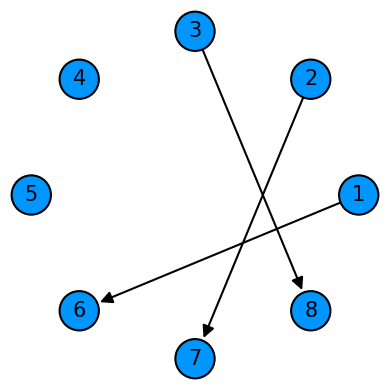

In [101]:
cycle = Qcycle(stride=5, step=1,offset=0, mapping=u1_2, boundary="open")
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

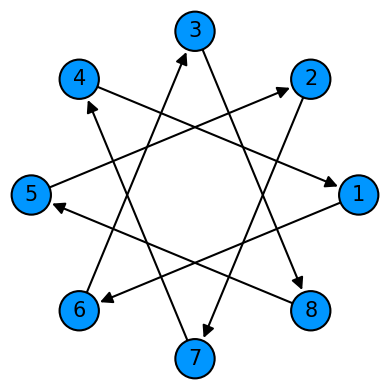

In [102]:
cycle = Qcycle(stride=5, step=1,offset=0, mapping=u1_2, boundary="periodic")
cycle = Qinit(8) + cycle
plot_motif(cycle[1])

#### N qubit unitaries
For N-qubit unitaries other than N=2, the cycle primitive becomes a hypergraph. `stride`, `step` and `offset` still has the same meaning but now the edges are N-ary tuples. For example a stride of 3 causes edges of the form (1,4,7) for a 3-qubit unitary. This means the function gets sent bits 1,4,7 in that order. Consider the same 3 qubit unitary defined with pennylane, qiskit or cirq

In [103]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def U3(bits, symbols=None, circuit=None):
        q0, q1, q2 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1]), QuantumRegister(1, bits[2])
        circuit.crz(symbols[0], q0, q1)
        circuit.crx(symbols[1], q2, q1)
        return circuit

elif backend == "cirq":
    import cirq
    def U3(bits, symbols=None, circuit=None):
        q0, q1, q2 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1]), cirq.LineQubit(bits[2])
        circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
        circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q2)
        return circuit

elif backend == "pennylane":
    def U3(bits, symbols=None):
        qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
        qml.CRX(symbols[1], wires=[bits[2], bits[1]])
u3 = Qunitary(U3, 2, 3)

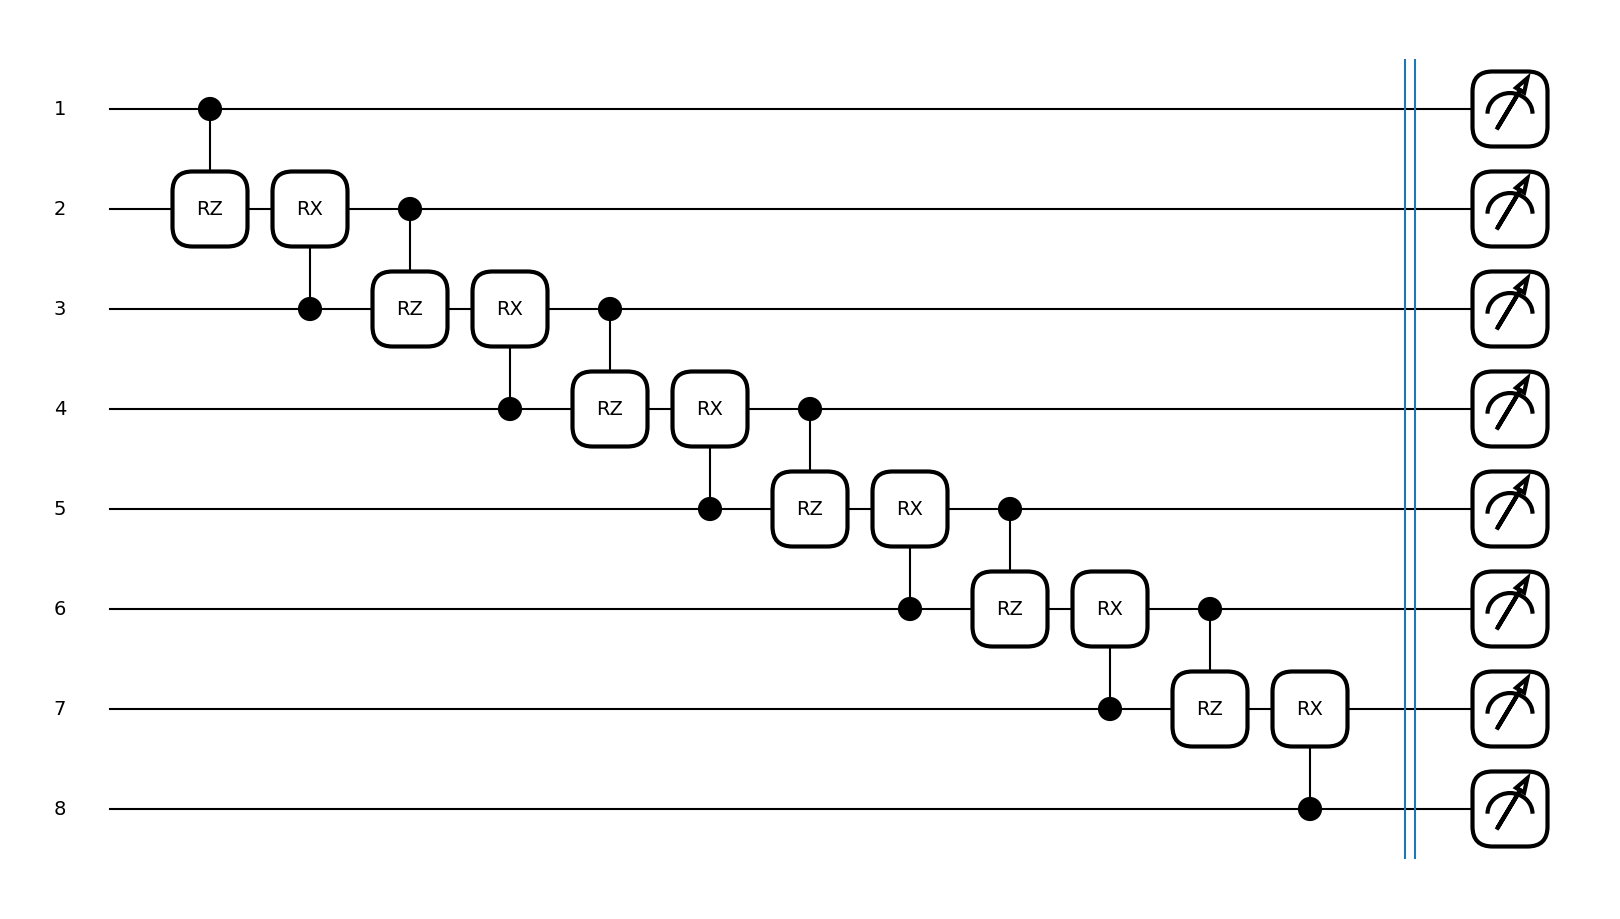

In [104]:
cycle = Qcycle(stride=1, step=1,offset=0, mapping=u3, boundary="open")
cycle = Qinit(8) + cycle
circuit = get_circuit(cycle)
draw_circuit(circuit)

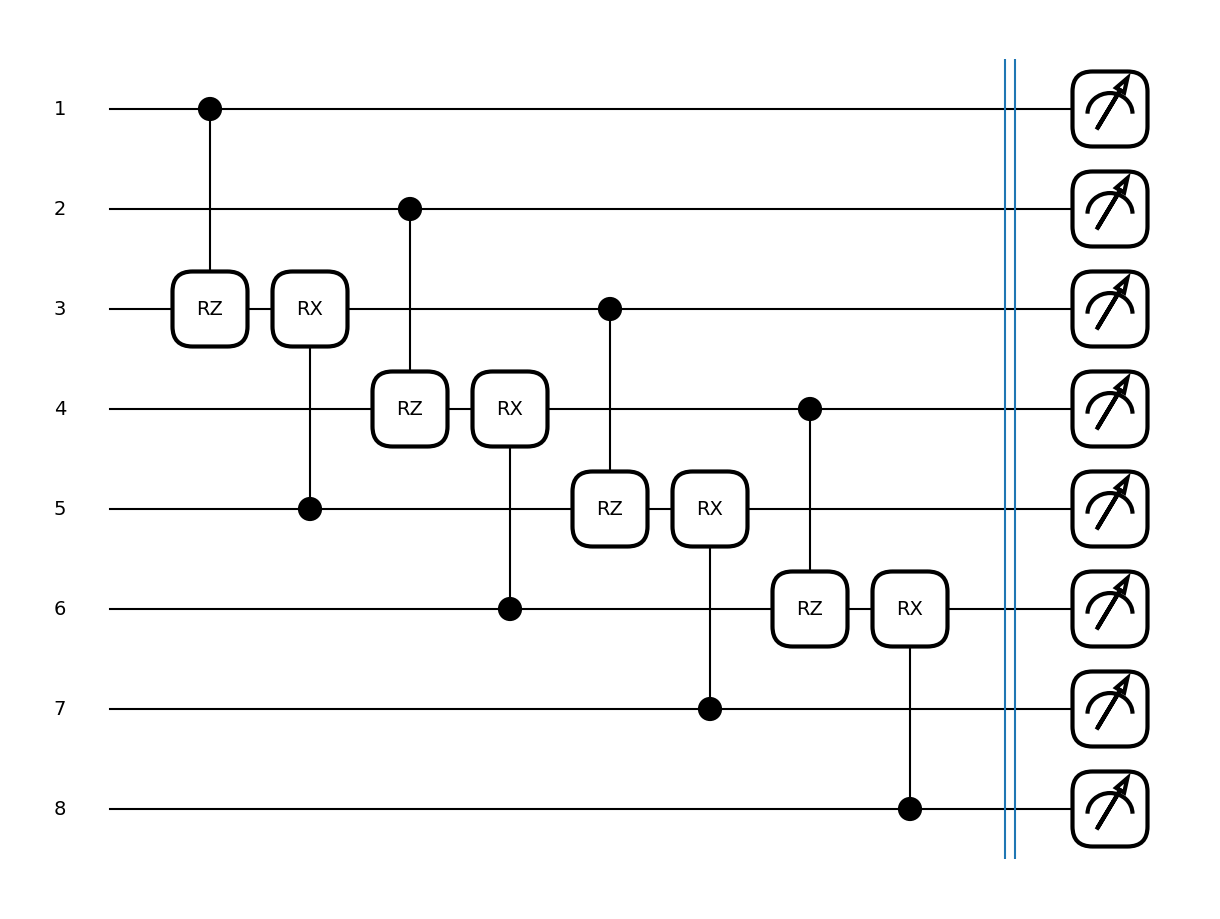

In [105]:
cycle = Qcycle(stride=2, step=1,offset=0, mapping=u3, boundary="open")
cycle = Qinit(8) + cycle
circuit = get_circuit(cycle)
draw_circuit(circuit)

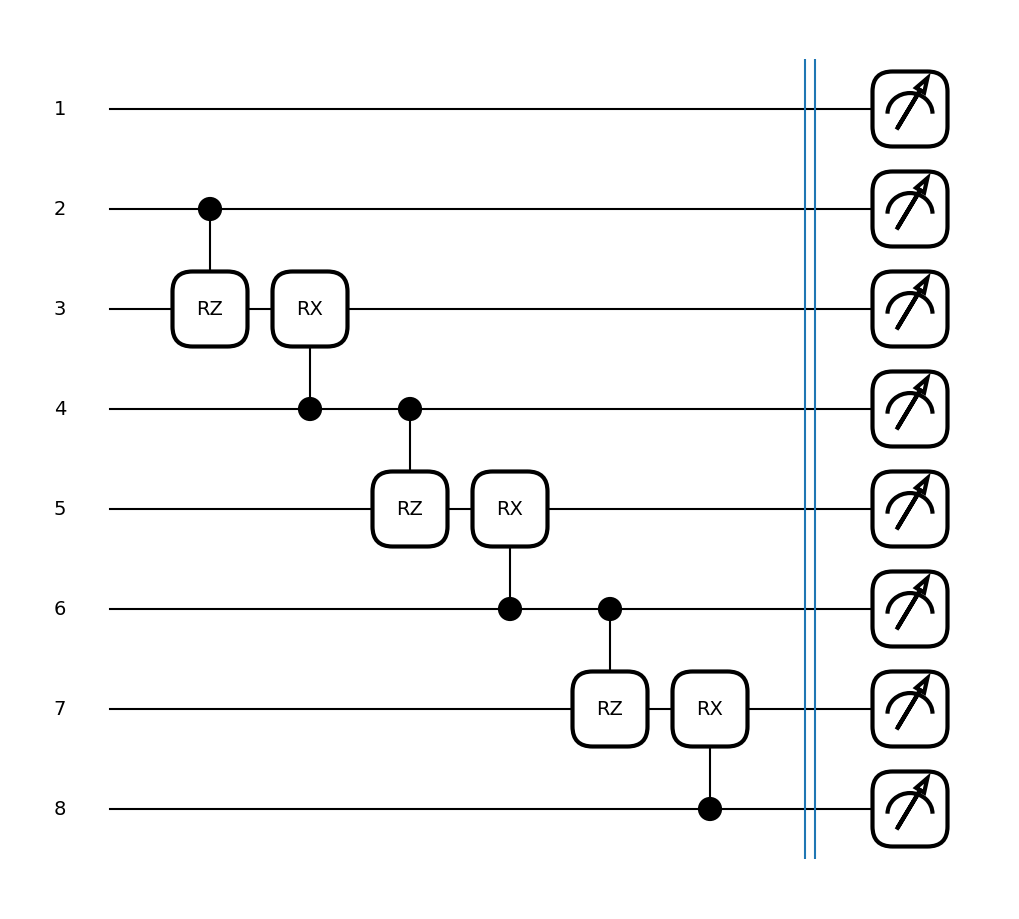

In [106]:
cycle = Qcycle(stride=1, step=2,offset=1, mapping=u3, boundary="open")
cycle = Qinit(8) + cycle
circuit = get_circuit(cycle)
draw_circuit(circuit)

### Qpermute primitive
`Qpermute` is a simple primitive that generates all combinations or permutations of edges based on the `combinations` hyperparameter and `arity` of corresponding function:
```python
if self.combinations:
    E = list(it.combinations(Q, r=self.arity))
else:
    E = list(it.permutations(Q, r=self.arity))
```
Where E is the generated edges and Q the available qubits of the primitive

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

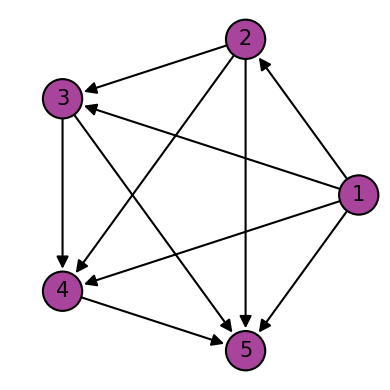

In [107]:
permute = Qpermute()
permute_5_qubits = Qinit(5) + permute
plot_motif(permute_5_qubits[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

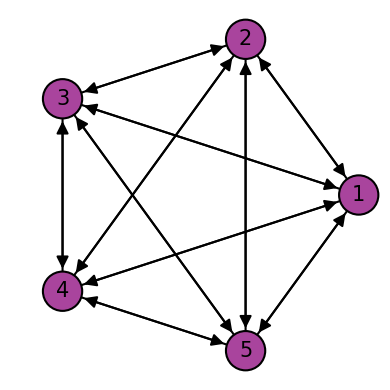

In [108]:
permute = Qpermute(combinations=False)
permute_5_qubits = Qinit(5) + permute
plot_motif(permute_5_qubits[1])

In [109]:
permute = Qpermute(combinations=False, mapping=u2_3)
permute_5_qubits = Qinit(5) + permute
print(permute_5_qubits[1].E)

[(1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 2), (1, 3, 4), (1, 3, 5), (1, 4, 2), (1, 4, 3), (1, 4, 5), (1, 5, 2), (1, 5, 3), (1, 5, 4), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 3, 1), (2, 3, 4), (2, 3, 5), (2, 4, 1), (2, 4, 3), (2, 4, 5), (2, 5, 1), (2, 5, 3), (2, 5, 4), (3, 1, 2), (3, 1, 4), (3, 1, 5), (3, 2, 1), (3, 2, 4), (3, 2, 5), (3, 4, 1), (3, 4, 2), (3, 4, 5), (3, 5, 1), (3, 5, 2), (3, 5, 4), (4, 1, 2), (4, 1, 3), (4, 1, 5), (4, 2, 1), (4, 2, 3), (4, 2, 5), (4, 3, 1), (4, 3, 2), (4, 3, 5), (4, 5, 1), (4, 5, 2), (4, 5, 3), (5, 1, 2), (5, 1, 3), (5, 1, 4), (5, 2, 1), (5, 2, 3), (5, 2, 4), (5, 3, 1), (5, 3, 2), (5, 3, 4), (5, 4, 1), (5, 4, 2), (5, 4, 3)]


### Qmask and Qunmask primitive

The `Qmask` primitive allows you to "mask" qubits according to a chosen pattern. Masking qubits in this context implies rendering certain qubits temporarily unavailable for subsequent operations, which facilitates specialized architectures and computations. You have the option to associate a unitary operation with the mask. The utility of this is that it "preserves" the information of the masked qubits, usually through a controlled unitary operation. This feature enables patterns of pooling in quantum neural networks, coarse graining,  entanglers and "deferred measurement" where masked qubits are the controls of unmasked ones.

For 2-qubit unitaries there are predefined masking patterns such as "right", "left", "inside", "outside", "even", "odd" which halves the circuit size. Alternatively, you can provide your own string such as "1\*1" where '1' signifies mask and "*" means to fill with 0's based on the number of available qubits. '0' signifies keeping the qubit active.

When specifying a unitary, there are three `connection_type` options (how to generate the edges):
  - "cycle", simlar to the cycle primitive, generate edges with a stride, step and offset parameter
  - "nearest_circle" connect each masked qubit to the nearest available qubit in a circular topology
  - "nearest_tower"  connect each masked qubit to the nearest available qubit in a tower topology

The Qunmask primitive allows you to "unmask" previously masked qubits, making them available for subsequent operations.

Examples will make this clearer:

#### Masking without a mapping
The small nodes are the masked ones

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

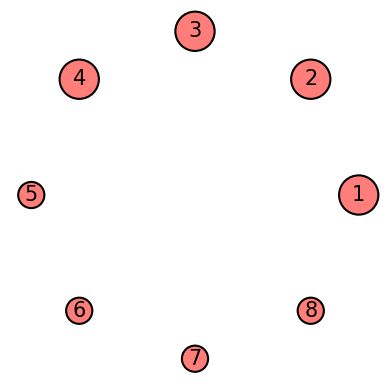

In [110]:
mask = Qinit(8) + Qmask("right")
plot_motif(mask[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

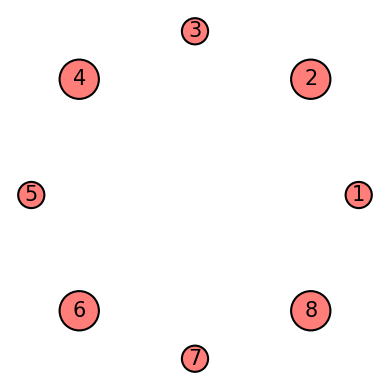

In [111]:
mask = Qinit(8) + Qmask("even")
plot_motif(mask[1])

This might be easier to see with a circuit and a mask between two cycles. We'll use the following 2 qubit unitaries for the cycles:

In [112]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def U2(bits, symbols=None, circuit=None):
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
        circuit.crz(symbols[0], q0, q1)
        return circuit

elif backend == "cirq":
    import cirq
    def U2(bits, symbols=None, circuit=None):
        q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
        circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
        return circuit

elif backend == "pennylane":
    def U2(bits, symbols=None):
        qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
u2 = Qunitary(U2, 1, 2)

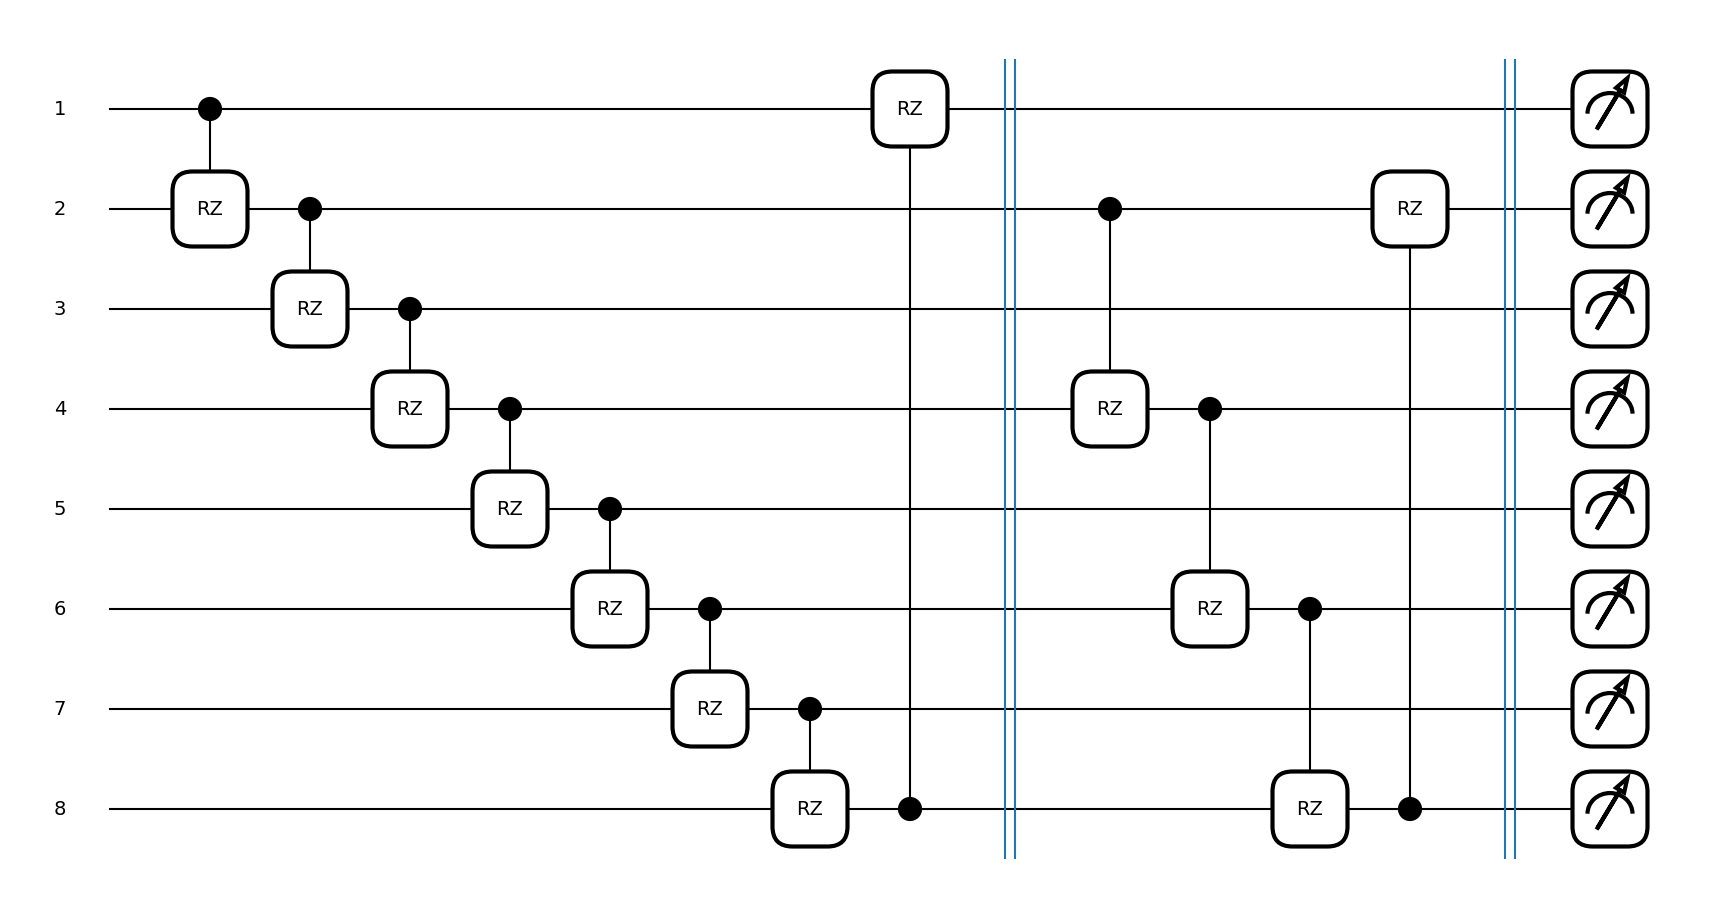

In [113]:
mask = Qinit(8) + Qcycle(mapping=u2) + Qmask("even") + Qcycle(mapping=u2)
circuit = get_circuit(mask)
draw_circuit(circuit)

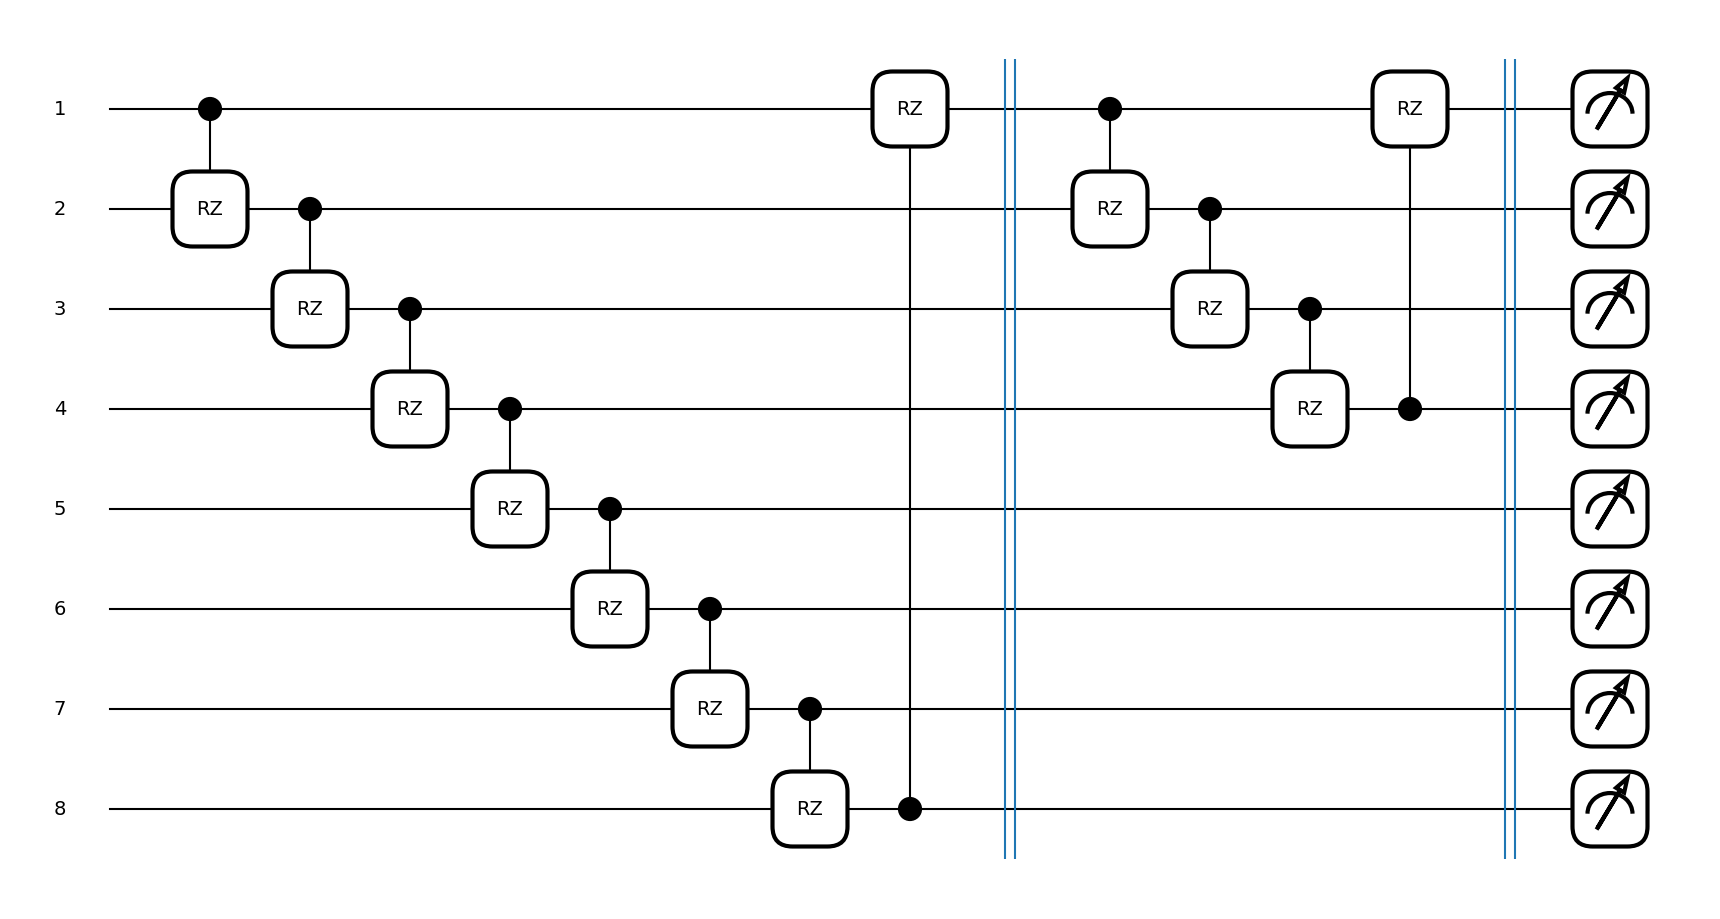

In [114]:
mask = Qinit(8) + Qcycle(mapping=u2) + Qmask("right") + Qcycle(mapping=u2)
circuit = get_circuit(mask)
draw_circuit(circuit)

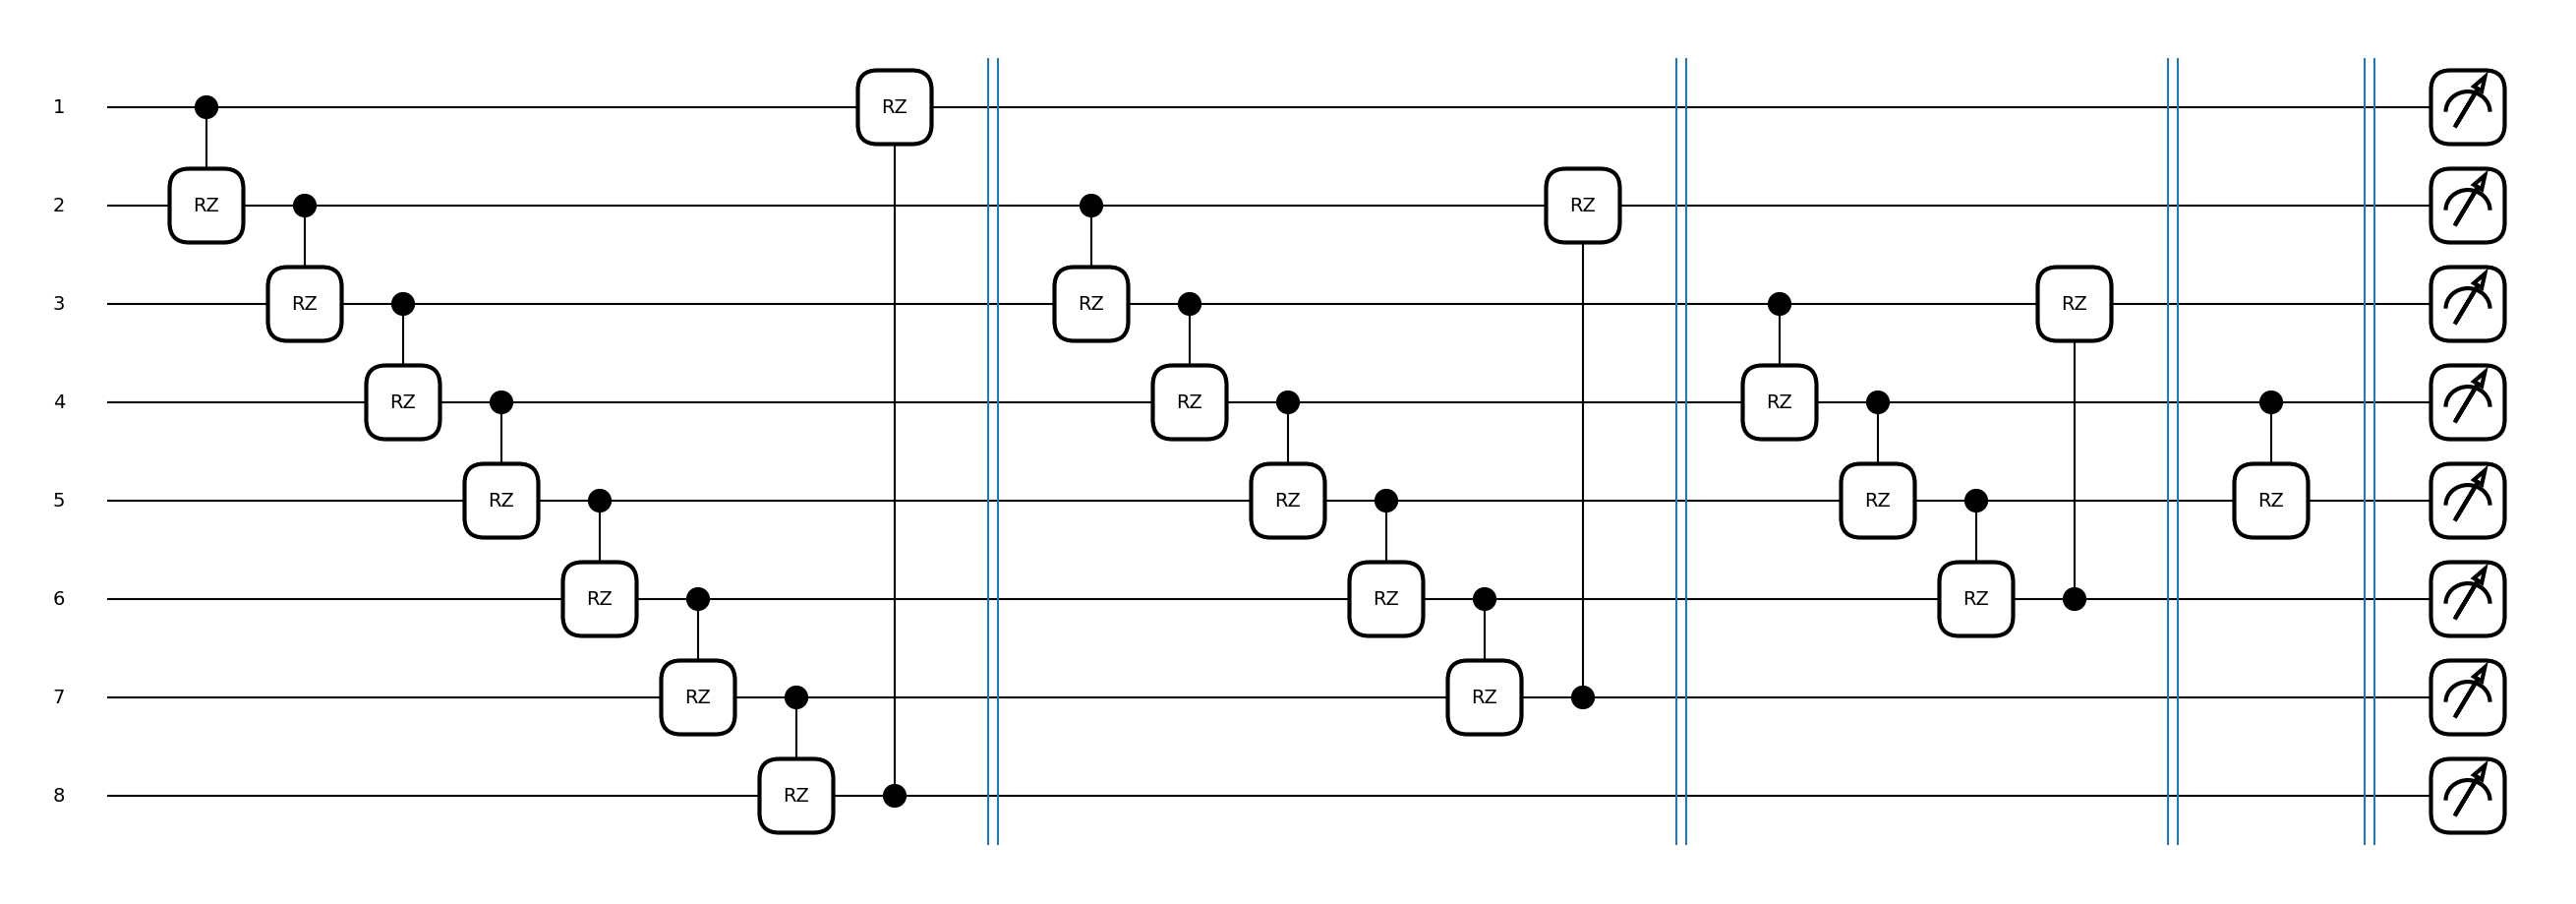

In [115]:
mask = Qinit(8) + Qcycle(mapping=u2) + (Qmask("1*1") + Qcycle(mapping=u2))*3
circuit = get_circuit(mask)
draw_circuit(circuit)

#### Masking with a mapping

In [116]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def V2(bits, symbols=None, circuit=None):
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
        circuit.cnot(q0, q1)
        return circuit

elif backend == "cirq":
    import cirq
    def V2(bits, symbols=None, circuit=None):
        q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
        circuit += cirq.CNOT(q1,q0)
        return circuit

elif backend == "pennylane":
    def V2(bits, symbols=None):
        qml.CNOT(wires=[bits[0], bits[1]])
v2 = Qunitary(V2, 0, 2)

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

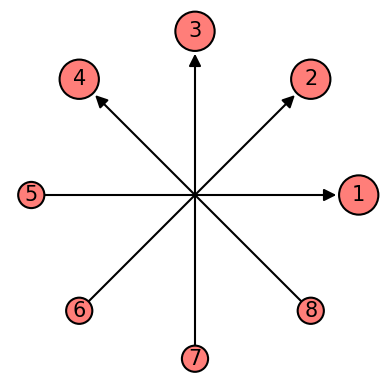

In [117]:
mask = Qinit(8) + Qmask("right", mapping=v2)
plot_motif(mask[1])

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

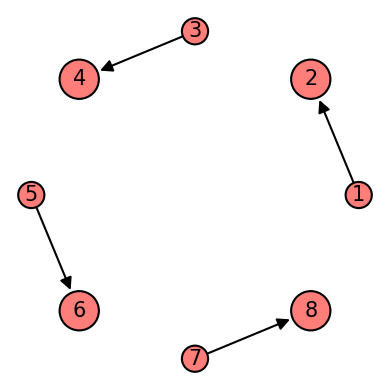

In [118]:
mask = Qinit(8) + Qmask("even", mapping=u2)
plot_motif(mask[1])

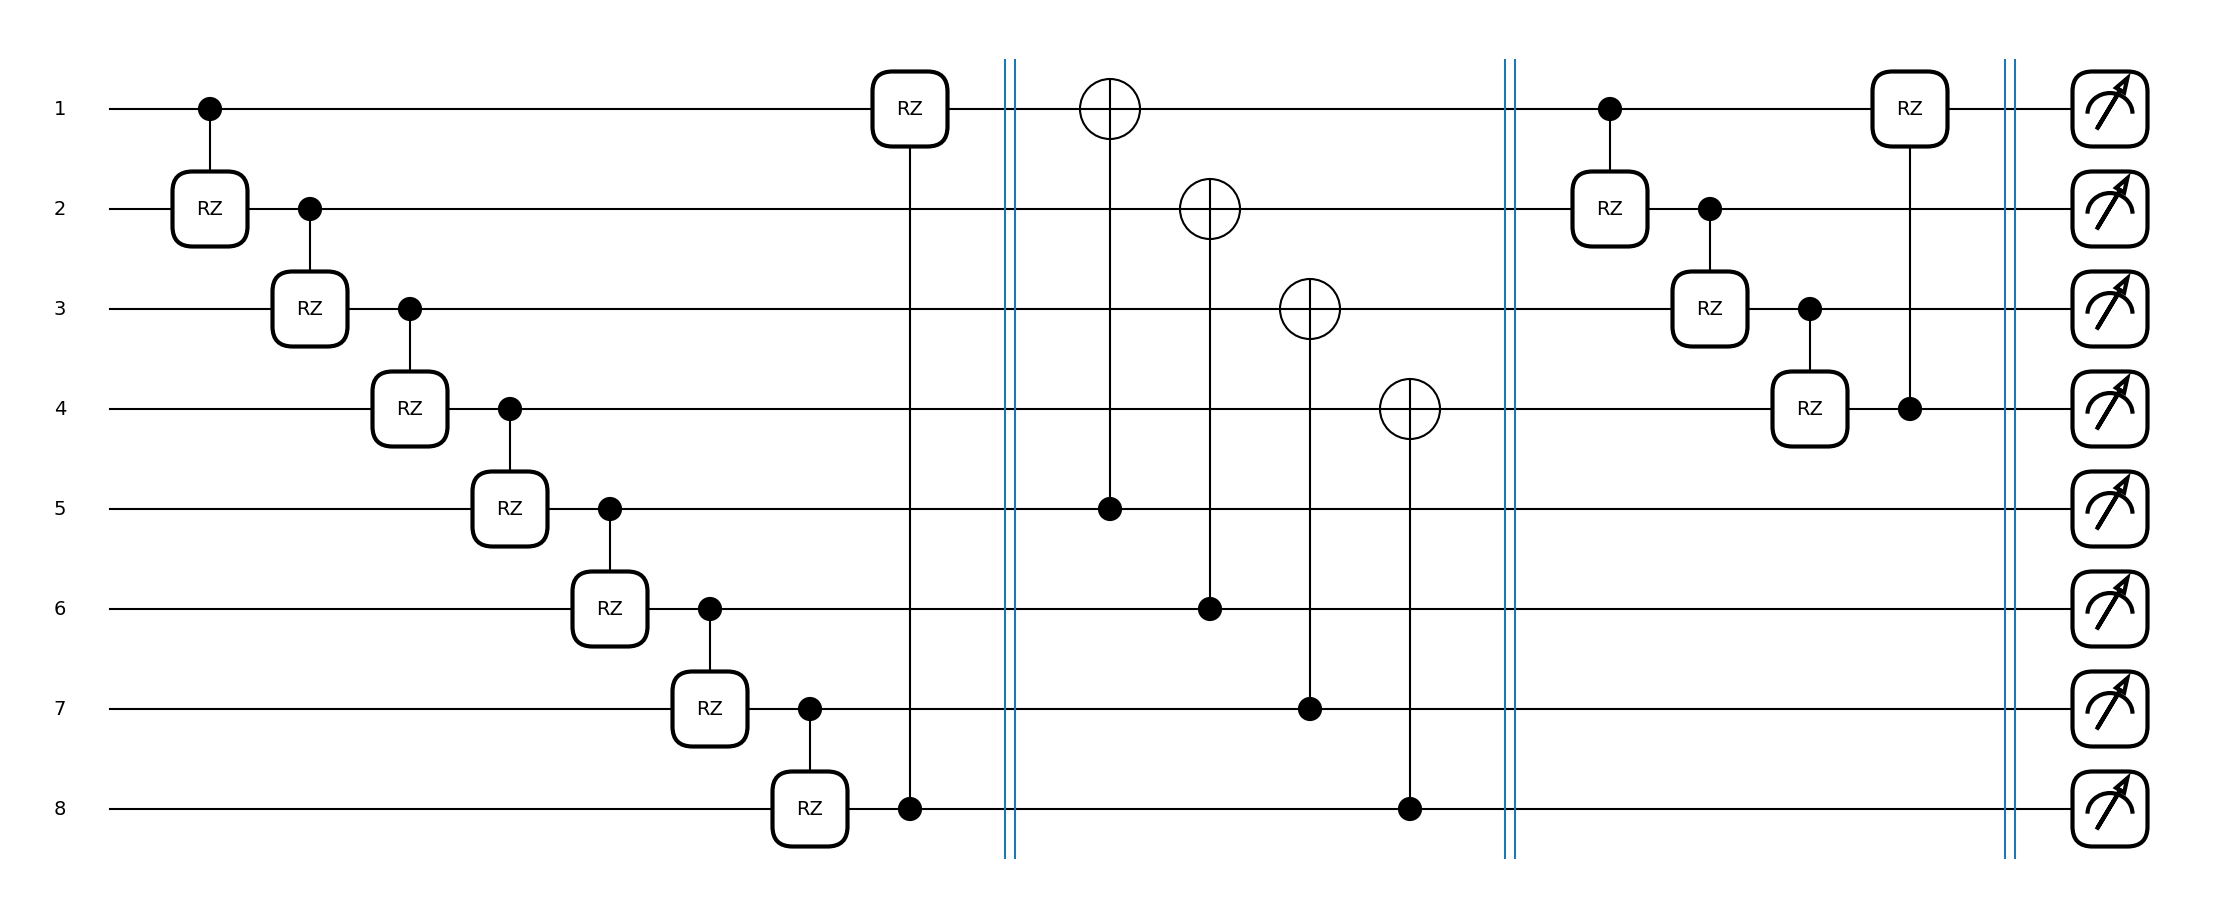

In [119]:
mask = Qinit(8) + Qcycle(mapping=u2) + Qmask("right", mapping=v2) + Qcycle(mapping=u2)
circuit = get_circuit(mask)
draw_circuit(circuit)

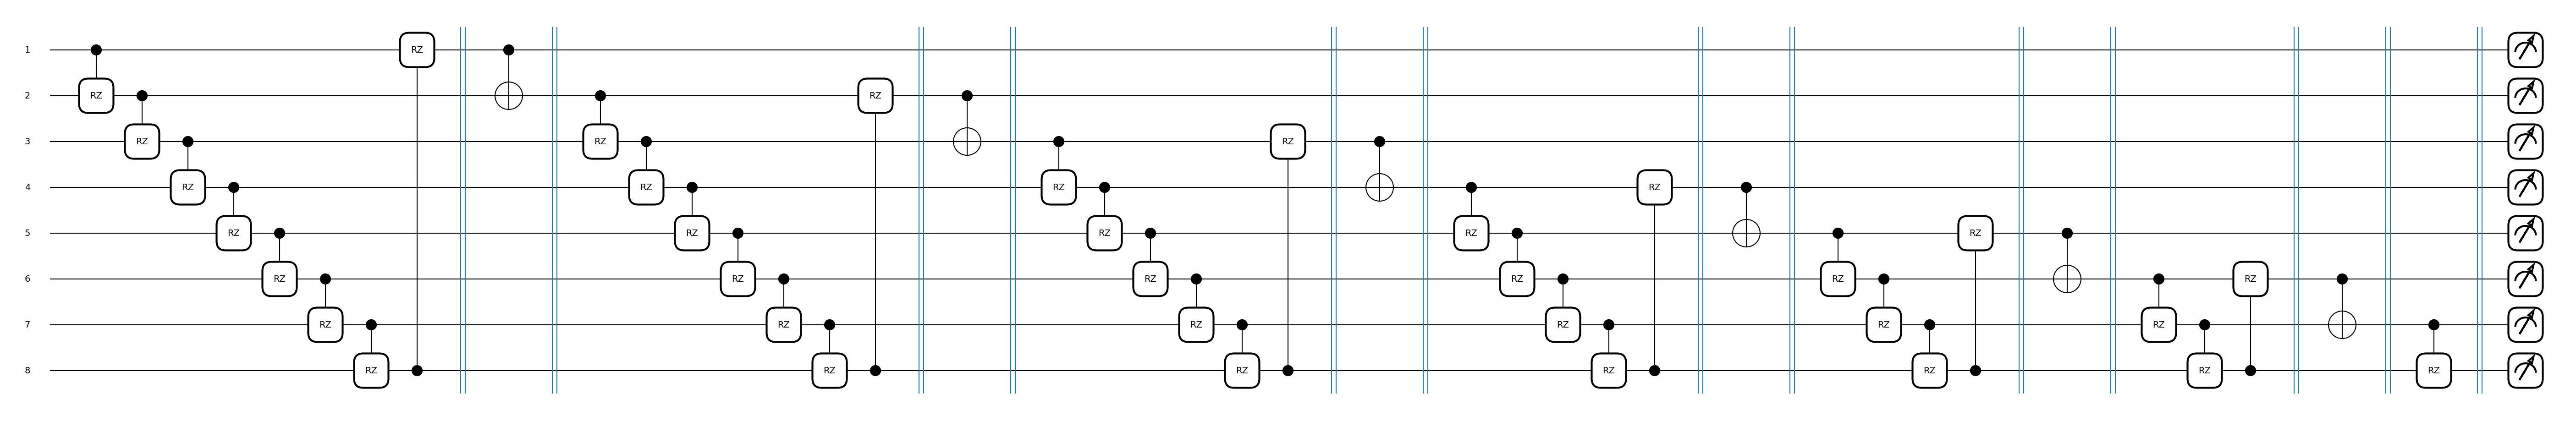

In [120]:
mask = Qinit(8) + Qcycle(mapping=u2) + (Qmask("1*", mapping=v2) + Qcycle(mapping=u2))*6
circuit = get_circuit(mask)
draw_circuit(circuit)

#### N-qubit unitaries
For N qubit unitaries, the pattern provided applies within the unitary. For example a pattern of "101" means for each edge of the form (a,b,c), a and c are going to be masked. Therefore the pattern string needs to be the same length as the arity for N>2 unitaries.

In [121]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def V3(bits, symbols=None, circuit=None):
        q0, q1, q2 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1]), QuantumRegister(1, bits[2])
        circuit.cnot(q0, q1)
        circuit.cnot(q2, q1)
        return circuit

elif backend == "cirq":
    import cirq
    def V3(bits, symbols=None, circuit=None):
        q0, q1, q2 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1]), cirq.LineQubit(bits[2])
        circuit += cirq.CNOT(q1, q0)
        circuit += cirq.CNOT(q1, q2)
        return circuit

elif backend == "pennylane":
    def V3(bits, symbols=None):
        qml.CNOT(wires=[bits[0], bits[1]])
        qml.CNOT(wires=[bits[2], bits[1]])
v3 = Qunitary(V3, 0, 3)

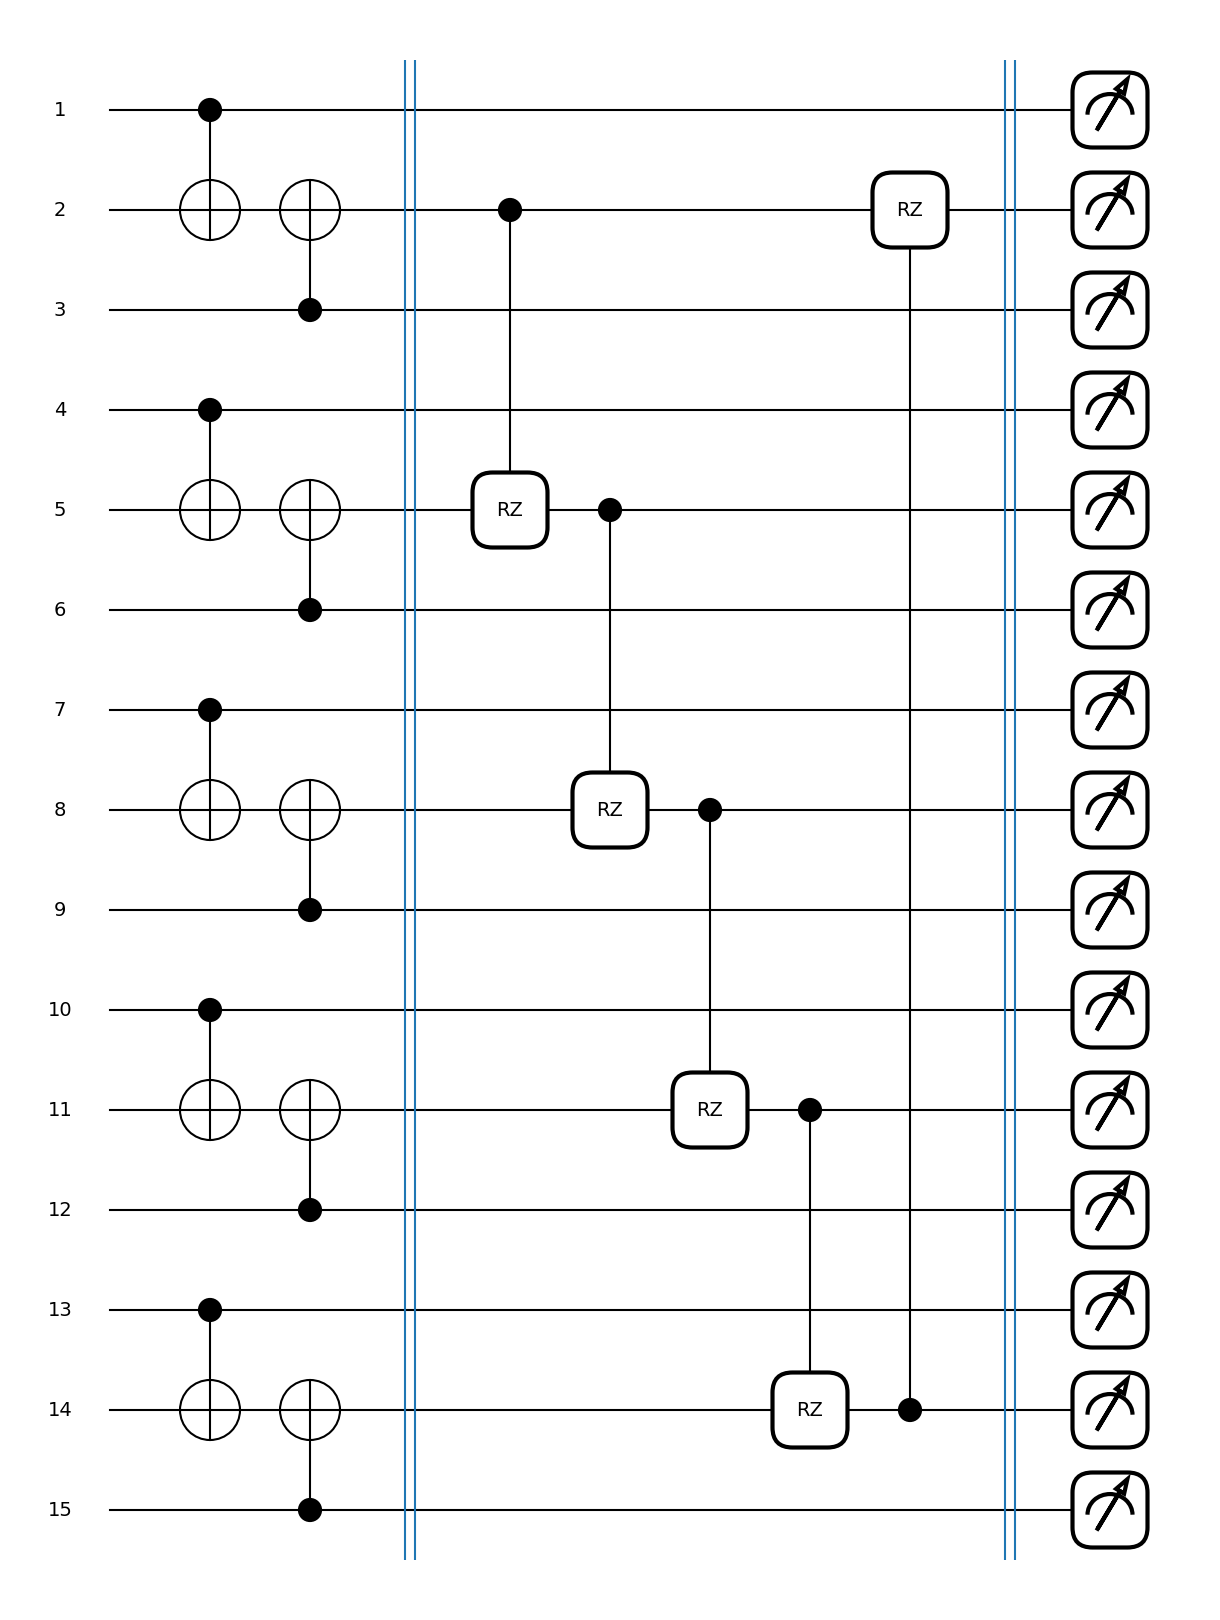

In [122]:
mask = Qinit(15) + Qmask("101", stride=1, step=3, offset=0, mapping=v3) + Qcycle(mapping=u2) 
circuit = get_circuit(mask)
draw_circuit(circuit)

#### Qunmask example

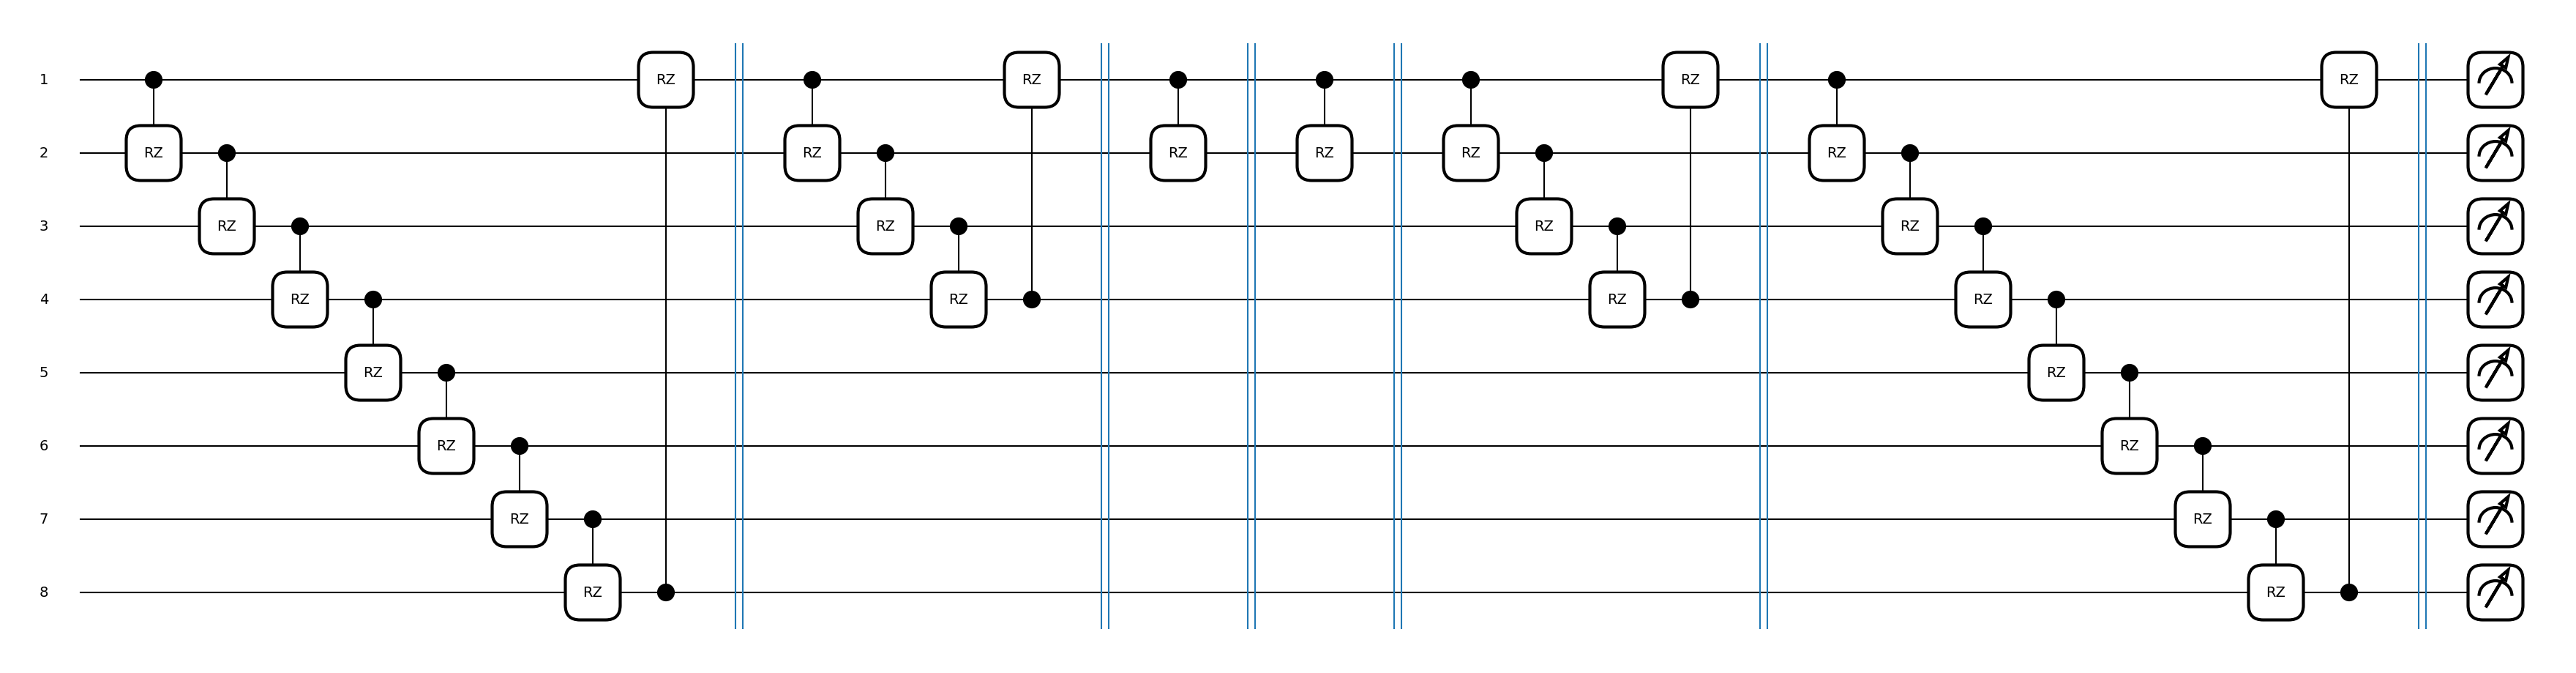

In [123]:
hierq = Qinit(8) + (Qcycle(1, 1, 0, mapping=u2) + Qmask("right"))*3 + (Qunmask("previous") + Qcycle(1, 1, 0, mapping=u2))*3
circuit = get_circuit(hierq)
draw_circuit(circuit)